# Chapter 16

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [88]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    
try:
    import modsim
except ImportError:
    !pip install modsimpy

## Code from previous notebooks

In [89]:
def change_func(T, t, system):
    r, T_env, dt = system.r, system.T_env, system.dt
    
    return -r * (T - T_env) * dt

In [254]:
from modsim import TimeSeries
from numpy import arange

def run_simulation(system, change_func):
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    results = TimeSeries(quantity='Temperature')
    results[t_0] = system.T_init
    
    for t in arange(t_0, t_end, dt):
        T = results[t]
        results[t+dt] = T + change_func(T, t, system)
    
    system.t_end = results.index[-1]
    system.T_final = results[system.t_end]
    return results

In [255]:
from modsim import System

def make_system(T_init, volume, r, t_end):
    return System(T_init=T_init,
                  T_final=T_init,
                  volume=volume,
                  r=r,
                  t_end=t_end,
                  T_env=22,
                  t_0=0,
                  dt=0.1)

In the previous chapter we wrote a simulation of a cooling cup of
coffee. Given the initial temperature of the coffee, the temperature of the atmosphere, and the rate parameter, `r`, we can predict how the
temperature of the coffee will change over time.

In general, we don't know the value of `r`, but we can use measurements to estimate it. Given an initial temperature, a final temperature, and the time in between, we can find `r` by trial and error.

In this chapter, we'll see a better way to find `r`, using a **bisection search**.

And then we'll get back to solving the coffee cooling problem.

## Finding roots

The ModSim library provides a method called `root_bisect` that finds the roots of non-linear equations. As a simple example, suppose you want to find the roots of the polynomial 

$$f(x) = (x - 1)(x - 2)(x - 3)$$ 

where **root** means a value of $x$ that makes $f(x)=0$. Because of the way I wrote the polynomial, we can see that if $x=1$, the first factor is 0; if $x=2$, the second factor is 0; and if $x=3$, the third factor is 0, so those are the roots.

I'll use this example to demonstrate `root_bisect`. First, we have to
write a function that evaluates $f$:

In [256]:
def func(x):
    return (x-1) * (x-2) * (x-3)

Now we call `root_bisect` like this:

In [257]:
from scipy.optimize import root_scalar

res = root_scalar(func, bracket=[1.5, 2.5])
res

      converged: True
           flag: 'converged'
 function_calls: 3
     iterations: 2
           root: 2.0

The first argument is the function whose roots we want. The second
argument is an interval that contains a root. The result is an object
that contains several variables, including `root`, which stores the root
that was found.

If we provide a different interval, we find a different root.

In [258]:
res = root_scalar(func, bracket=[2.5, 3.5])

res.root

3.0

If the interval doesn't contain a root, you'll get a `ValueError`:

```
res = root_scalar(func, bracket=[4, 5])
```

## Estimating `r`

So how can we use `root_scalar` to estimate `r`?

What we want is the value of `r` that yields a final temperature of
70 °C. To work with `root_scalar`, we need a function that takes `r` as a parameter and returns the difference between the final temperature and the goal:

In [259]:
def error_func(r, system):
    system.r = r
    results = run_simulation(system, change_func)
    return system.T_final - 70

I call a function like this an "error function\" because it returns the
difference between what we got and what we wanted, that is, the error.
When we find the right value of `r`, this error will be 0.

We can test `error_func` like this, using the initial guess `r=0.01`:

In [260]:
coffee = make_system(T_init=90, volume=300, r=0.01, t_end=30)
error_func(0.01, coffee)

KeyError: 0.6000000000000001

The result is an error of 2.3 °C, because the final temperature with
this value of `r` is too high.

In [165]:
error_func(0.02, coffee)

-10.907066281994297

With `r=0.02`, the error is  about -11°C, which means that the final temperature is too low. So we know that the correct value must be in between.

Now we can call `root_scalar` like this:

In [166]:
res = root_scalar(error_func, coffee, bracket=[0.01, 0.02])

The first argument is the error function.
The second argument is the `System` object, which `root_scalar` will pass as an argument to `error_func`.
The third argument is an interval that brackets the root.

Here are the results.

In [167]:
res

      converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 0.011543084584004043

In [170]:
r_coffee = res.root
r_coffee

0.011543084584004043

In this example, `r_coffee` turns out to be about `0.0115`, in units of min$^{-1}$ (inverse minutes).

We can confirm that this value is correct by setting `r` to the root we found and running the simulation.

In [171]:
coffee.r = res.root
results = run_simulation(coffee, change_func)
coffee.T_final

69.99999999996255

The result is very close to 70 C.

## Mixing liquids

When we mix two liquids, the temperature of the mixture depends on the
temperatures of the ingredients, but it might not be obvious how to
compute it.

Assuming there are no chemical reactions that either produce or consume heat, the total thermal energy of the system is the same before and after mixing; in other words, thermal energy is **conserved**.

If the temperature of the first liquid is $T_1$, the temperature of the second liquid is $T_2$, and the final temperature of the mixture is $T$, the heat transfer into the first liquid is $C_1 (T - T_1)$ and the heat transfer into the second liquid is $C_2 (T - T_2)$, where $C_1$ and $C_2$ are the thermal masses of the liquids.

In order to conserve energy, these heat transfers must add up to 0:

$$C_1 (T - T_1) + C_2 (T - T_2) = 0$$ 

We can solve this equation for T:

$$T = \frac{C_1 T_1 + C_2 T_2}{C_1 + C_2}$$ 

For the coffee cooling problem, we have the volume of each liquid; if we also know the density, $\rho$, and the specific heat capacity, $c_p$, we can compute thermal mass: 

$$C = \rho V c_p$$ 

If the liquids have the same density and heat capacity, they drop out of the equation, and we can write:

$$T = \frac{V_1 T_1 + V_2 T_2}{V_1 + V_2}$$ 

where $V_1$ and $V_2$ are the volumes of the liquids.

As an approximation, I'll assume that milk and coffee have the same
density and specific heat. As an exercise, you can look up these
quantities and see how good this assumption is.

The following function takes two `System` objects that represent the
coffee and milk, and creates a new `System` to represent the mixture:

In [172]:
def mix(system1, system2):
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.T_final, system2.T_final
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       volume=V_mix,
                       r=system1.r,
                       t_end=30)

The first two lines extract volume and temperature from the two `System` objects. Then the following two lines compute the volume and temperature of the mixture. Finally, `mix` makes a new `System` object and returns it.

This function uses the value of `r` from `system1` as the value of `r`
for the mixture. If `system1` represents the coffee, and we are adding
the milk to the coffee, this is probably a reasonable choice. On the
other hand, when we increase the amount of liquid in the coffee cup,
that might change `r`. So this is an assumption we might want to
revisit.

Now we have everything we need to solve the problem.

## Mix first or last?

First I'll create objects to represent the coffee and cream.
For `r_coffee`, I'll use the value we just computed.

In [235]:
coffee = make_system(T_init=90, volume=300, r=r_coffee, t_end=30)

For `r_milk`, I'll use the value I estimated in the exercise from the previous chapter.

In [236]:
r_milk = 0.133
milk = make_system(T_init=5, volume=50, r=r_milk, t_end=15)

Now we can mix them and simulate 30 minutes:

In [237]:
mix_first = mix(coffee, milk)
run_simulation(mix_first, change_func)

mix_first.T_final

61.428571428540685

The final temperature is 61.4 °C which is still warm enough to be
enjoyable. Would we do any better if we added the milk last?

I'll simulate the coffee and milk separately, and then mix them:

In [152]:
coffee_results = run_simulation(coffee, change_func)
run_simulation(milk, change_func)
mix_last = mix(coffee, milk)
mix_last.T_final

63.10928927119819

After mixing, the temperature is 63.1 °C, so it looks like adding the
milk at the end is better by about 1.7 °C. But is that the best we can
do?

## Optimization

Adding the milk after 30 minutes is better than adding it immediately, but maybe there's something in between that's even better. To find out, I'll use the following function, which takes the time to add the milk, `t_add`, as a parameter:

In [177]:
def run_and_mix(t_add, t_total):
    coffee.t_end = t_add
    coffee_results = run_simulation(coffee, change_func)
    
    milk.t_end = t_add
    milk_results = run_simulation(milk, change_func)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_simulation(mixture, change_func)

    return mixture.T_final

When `t_add=0`, we add the milk immediately; when `t_add=30`, we add it
at the end. Now we can sweep the range of values in between:

In [238]:
coffee = make_system(T_init=90, volume=300, r=r_coffee, t_end=30)

In [245]:
milk = make_system(T_init=5, volume=50, r=0.133, t_end=15)

In [246]:
from modsim import SweepSeries
from numpy import linspace

sweep = SweepSeries()
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the results look like:

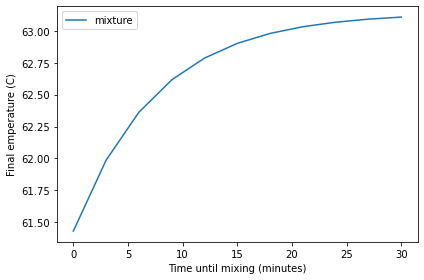

In [247]:
from modsim import decorate

sweep.plot(label='mixture')

decorate(xlabel='Time until mixing (minutes)',
         ylabel='Final emperature (C)')

Note that this is a parameter sweep, not a time series. The x-axis is the time when we add the milk, not the index of a `TimeSeries`.

The final temperature is maximized when `t_add=30`, so adding the milk
at the end is optimal.

As an exercise you will have a chance to explore this solution and try some variations. For example, suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office. In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

## Analysis

Simulating Newton's law of cooling is almost silly, because we can solve the differential equation analytically. If

$$\frac{dT}{dt} = -r (T - T_{env})$$ 

the general solution is

$$T{\left (t \right )} = C \exp(-r t) + T_{env}$$ 

and the particular solution where $T(0) = T_{init}$ is

$$T_{env} + \left(- T_{env} + T_{init}\right) \exp(-r t)$$ 

If you would like to see this solution done by hand, you can watch this video: <http://modsimpy.com/khan3>.

Now we can use the observed data to estimate the parameter $r$. If we
observe the that temperature at $t_{end}$ is $T_{final}$, we can plug these values into the particular solution and solve for $r$. The result is:

$$r = \frac{1}{t_{end}} \log{\left (\frac{T_{init} - T_{env}}{T_{final} - T_{env}} \right )}$$

The following function takes a `System` object with a simulated `T_final` and computes `r`:

In [193]:
from numpy import log

def compute_r(system):
    t_end = system.t_end
    T_init = system.T_init
    T_final = system.T_final
    T_env = system.T_env
    
    r = log((T_init - T_env) / (T_final - T_env)) / t_end
    return r

Can can use this function to compute `r` for the coffee, given the parameters of the problem.

In [198]:
coffee = make_system(T_init=90, volume=300, r=0, t_end=30)
coffee.T_final = 70
r_coffee2 = compute_r(coffee)
r_coffee2

0.01161022314227386

Notice that this value is not the same as `r_coffee` in the simulations.  

In [199]:
r_coffee

0.011543084584004043

That's because the simulations use discrete time steps, and the analysis uses continuous time.

Nevertheless, the results of any analysis are consistent with the simulation.
To check, we'll use the following function, which takes a `System` object and uses the analytic result to compute a time series:

In [204]:
from numpy import exp
from pandas import Series

def run_analysis(system):
    T_env, T_init, r = system.T_env, system.T_init, system.r
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    t_array = arange(t_0, t_end+dt, dt)    
    T_array = T_env + (T_init - T_env) * exp(-r * t_array)
    
    system.T_final = T_array[-1]
    return Series(T_array, index=t_array)

The first two lines unpack the system variables.
`t_array` is a NumPy array of time stamps.
`T_array` is and array of the corresponding temperatures.
The result is a Pandas `Series`.

We can run it like this:

In [205]:
coffee2 = make_system(T_init=90, r=r_coffee2, 
                      volume=300, t_end=30)
results2 = run_analysis(coffee2)

In [206]:
coffee2.T_final

70.0

The final temperature is 70 °C, as it should be. In fact, the results
are identical to what we got by simulation, with a small difference due to rounding.

In [ ]:
coffee = make_system(T_init=90, volume=300, r=r_coffee, t_end=30)
results = run_simulation(coffee, change_func)

In [209]:
from numpy import allclose

allclose(results, results2)

True

## Exercises

**Exercise:** Use `root_scalar` to estimate `r_milk`, given that it starts at 5 °C and reaches 20 °C after 15 minutes.  

1. Write an error function that takes a possible value of `r`, runs a simulation, and returns the difference between `T_final` and 20 °C.

2. Try your error function and find two values of `r` that bracket a root.

3. Use `root_scalar` to compute `r_milk`.

4. Run the simulation with the computed value and confirm that `T_final` is 20 °C.

In [217]:
# Solution

def error_func2(r):
    system = make_system(T_init=5, volume=50, r=r, t_end=15)
    run_simulation(system, change_func)
    return system.T_final - 20

In [218]:
# Solution

error_func2(r=0.1)

-1.500149245609034

In [219]:
# Solution

error_func2(r=0.2)

1.4018656744898585

In [220]:
# Solution

res = root_scalar(error_func2, bracket=[0.1, 0.2])
res

      converged: True
           flag: 'converged'
 function_calls: 9
     iterations: 8
           root: 0.13296078935466452

In [221]:
# Solution

r_milk = res.root

In [224]:
# Solution

milk = make_system(T_init=5, volume=50, r=r_milk, t_end=15)
results = run_simulation(milk, change_func)
milk.T_final

19.999999999999996

**Exercise:** Use `compute_r` to compute `r_milk` according to the analytic solution.  Run the analysis with this value of `r_milk` and confirm that the results are consistent with the simulation.

In [229]:
# Solution

milk = make_system(T_init=5, volume=50, r=0, t_end=15)
milk.T_final = 20
r_milk2 = compute_r(milk)
r_milk2

0.14267107756641806

In [230]:
# Solution

milk2 = make_system(T_init=5, volume=50, r=r_milk2, t_end=15)
results2 = run_analysis(milk2)

In [231]:
# Solution

milk2.T_final

20.0

In [232]:
# Solution

from numpy import allclose

allclose(results, results2)

True

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

In [46]:
# Solution

# A refrigerator keeps the milk at a constant temperature,
# so it is like a container with r = 0.

# With T_init=5 and r_milk = 0, 
# it is best to add the milk at the beginning.